# Kaggle - New York City Taxi Fare Prediction
## Data Set
[Kaggle - NY City Taxi Fare Prediction](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data)  
[참고 노트북 | Cleansing+EDA+Modelling(LGBM + XGBoost starters)](https://www.kaggle.com/code/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters)  
[참고 노트북 | NYC Taxi Fare - Data Exploration](https://www.kaggle.com/code/breemen/nyc-taxi-fare-data-exploration)  
개인적으로 묻지마! lgbm이라서..

## 사용 라이브러리

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
def reg_score(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true,y_pred))
    MAE = np.mean( np.abs((y_true - y_pred) / y_true) )
    NMAE =mean_absolute_error(y_true, y_pred)/ np.mean( np.abs(y_true) )
    MAPE = np.mean( np.abs((y_true - y_pred) / y_true) ) *100
    R2 = r2_score(y_true, y_pred)
    
    print(f"MSE: {np.round(MSE, 3)}\nRMSE: {np.round(RMSE, 3)}\nMAE: {np.round(MAE, 3)}\nNMAE: {np.round(NMAE, 3)}\nMAPE: {np.round(MAPE, 3)}\nR2: {np.round(R2, 3)}")


## Data Load

In [4]:
path = glob.glob("data/*")
path

['data\\GCP-Coupons-Instructions.rtf',
 'data\\sample_submission.csv',
 'data\\test.csv',
 'data\\train.csv']

In [5]:
train, test = pd.read_csv(path[3], nrows=1000000), pd.read_csv(path[2])

train.shape, test.shape

((1000000, 8), (9914, 7))

## EDA

In [6]:
set(train.columns.tolist()) - set(test.columns.tolist())

{'fare_amount'}

In [7]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [8]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


### 결측치 확인

In [9]:
train.isnull().mean()*100

key                  0.000
fare_amount          0.000
pickup_datetime      0.000
pickup_longitude     0.000
pickup_latitude      0.000
dropoff_longitude    0.001
dropoff_latitude     0.001
passenger_count      0.000
dtype: float64

### 이상치 버리기

In [10]:
temp1 = train[train["pickup_latitude"]<-90].index
temp2 = train[train["pickup_latitude"]>90].index

train.drop(temp1, axis=0, inplace=True)
train.drop(temp2, axis=0, inplace=True)
train.shape

(999988, 8)

In [13]:
temp1 = train[train["pickup_longitude"]<-180].index
temp2 = train[train["pickup_longitude"]>180].index

train.drop(temp1, axis=0, inplace=True)
train.drop(temp2, axis=0, inplace=True)
train.shape

(999977, 8)

In [15]:
temp1 = train[train["dropoff_latitude"]<-90].index
temp2 = train[train["dropoff_latitude"]>90].index

train.drop(temp1, axis=0, inplace=True)
train.drop(temp2, axis=0, inplace=True)
train.shape

(999969, 8)

In [16]:
temp1 = train[train["dropoff_latitude"]<-180].index
temp2 = train[train["dropoff_latitude"]>180].index

train.drop(temp1, axis=0, inplace=True)
train.drop(temp2, axis=0, inplace=True)
train.shape

(999969, 8)

### 파생 변수 생성

In [12]:
train["key"] = pd.to_datetime(train["key"])
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])

test["key"] = pd.to_datetime(test["key"])
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])

In [23]:
data = [train,test]
for _ in data:
    _['Year'] = _['pickup_datetime'].dt.year
    _['Month'] = _['pickup_datetime'].dt.month
    _['Date'] = _['pickup_datetime'].dt.day
    _['Day of Week'] = _['pickup_datetime'].dt.dayofweek
    _['Hour'] = _['pickup_datetime'].dt.hour

#### Haversine formula
$ haversine(θ) = sin²{θ \over 2} $  

a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)  
c = 2 * atan2( √a, √(1−a) )  
d = R ⋅ c  
d = Haversine distance

In [19]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for _ in data:
        R = 6371 # km, 지구의 반지름
        phi1 = np.radians(_[lat1])
        phi2 = np.radians(_[lat2])
        
        delta_phi = np.radians(_[lat2]-_[lat1])
        delta_lambda = np.radians(_[long2]-_[long2])
        
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        d = (R * c)
        _["H_Distance"] = d
    return d

In [20]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0       2.220556
1       2.203589
2       0.569429
3       1.798244
4       5.042468
          ...   
9909    1.846858
9910    3.027761
9911    8.850835
9912    7.372161
9913    0.572636
Length: 9914, dtype: float64

In [21]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.005313
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,7.861593
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.190675
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.774202
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.751765


In [22]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2.220556
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2.203589
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.569429
3,2012-12-01 21:12:12.000000200,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,1.798244
4,2012-12-01 21:12:12.000000300,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,5.042468


### 상관 관계
#### 승객의 수가 요금에 영향을 주나?

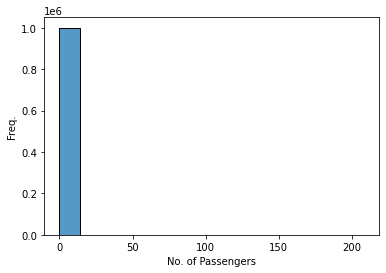

In [30]:
_ = sns.histplot(train["passenger_count"], bins=15)
plt.xlabel("No. of Passengers")
plt.ylabel("Freq.")
plt.show()

Text(0, 0.5, 'Fare')

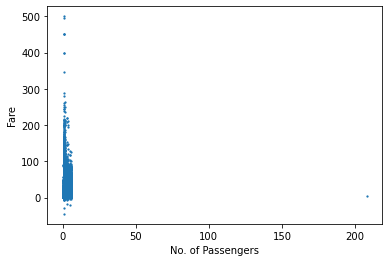

In [32]:
plt.scatter(x=train['passenger_count'], y=train['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

#### 픽업 날짜와 시간이 요금에 영향을 주나?

Text(0, 0.5, 'Fare')

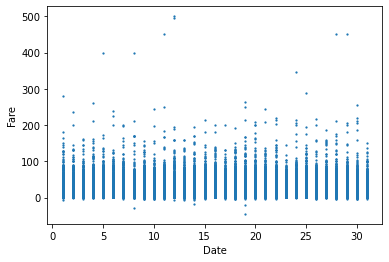

In [33]:
plt.scatter(x=train['Date'], y=train['fare_amount'], s=1.5)
plt.xlabel('Date')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

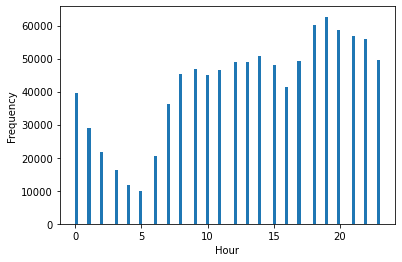

In [34]:
plt.hist(train['Hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

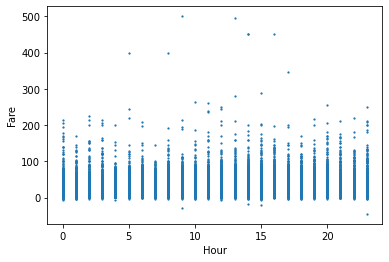

In [35]:
plt.scatter(x=train['Hour'], y=train['fare_amount'], s=1.5)
plt.xlabel('Hour')
plt.ylabel('Fare')

#### 요일이 요금에 영향을 주나?

Text(0, 0.5, 'Frequency')

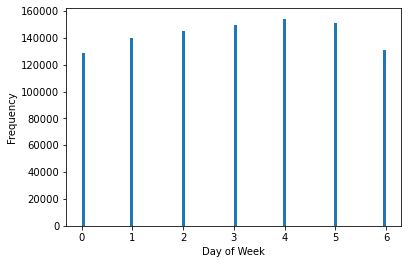

In [36]:
plt.hist(train['Day of Week'], bins=100)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

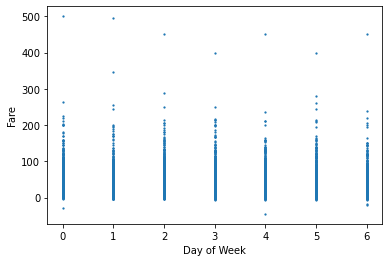

In [37]:
plt.scatter(x=train['Day of Week'], y=train['fare_amount'], s=1.5)
plt.xlabel('Day of Week')
plt.ylabel('Fare')

#### 거리가 요금에 영향을 주나?

In [38]:
bins_0 = train.loc[(train['H_Distance'] == 0), ['H_Distance']]
bins_1 = train.loc[(train['H_Distance'] > 0) & (train['H_Distance'] <= 10),['H_Distance']]
bins_2 = train.loc[(train['H_Distance'] > 10) & (train['H_Distance'] <= 50),['H_Distance']]
bins_3 = train.loc[(train['H_Distance'] > 50) & (train['H_Distance'] <= 100),['H_Distance']]
bins_4 = train.loc[(train['H_Distance'] > 100) & (train['H_Distance'] <= 200),['H_Distance']]
bins_5 = train.loc[(train['H_Distance'] > 200) & (train['H_Distance'] <= 300),['H_Distance']]
bins_6 = train.loc[(train['H_Distance'] > 300),['H_Distance']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-10'
bins_2['bins'] = '11-50'
bins_3['bins'] = '51-100'
bins_4['bins'] = '100-200'
bins_5['bins'] = '201-300'
bins_6['bins'] = '>300'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4,bins_5,bins_6])
#len(dist_bins)
dist_bins.columns

Index(['H_Distance', 'bins'], dtype='object')

Text(0, 0.5, 'Frequency')

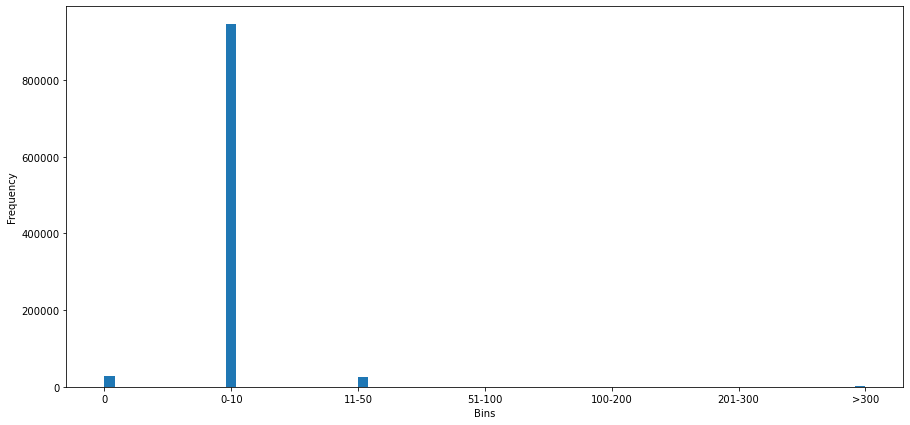

In [39]:
plt.figure(figsize=(15,7))
plt.hist(dist_bins['bins'], bins=75)
plt.xlabel('Bins')
plt.ylabel('Frequency')

In [40]:
train = train.drop(train.loc[((train['pickup_latitude']==0) & (train['pickup_longitude']==0))&((train['dropoff_latitude']!=0) & (train['dropoff_longitude']!=0)) & (train['fare_amount']==0)].index, axis=0)

In [42]:
train = train.drop(train.loc[((train['pickup_latitude']!=0) & (train['pickup_longitude']!=0))&((train['dropoff_latitude']==0) & (train['dropoff_longitude']==0)) & (train['fare_amount']==0)].index, axis=0)

In [44]:
train.shape

(999965, 14)

#### 장거리

In [49]:
high_distance = train.loc[(train['H_Distance']>200)&(train['fare_amount']!=0)]
high_distance.shape

(1715, 14)

In [48]:
high_distance.sample(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
837368,2012-07-06 10:52:22.000000100,6.9,2012-07-06 10:52:22+00:00,-74.004528,40.751124,0.000000,0.000000,1,4531.318244,2012,7,6,4,10
371095,2015-06-12 07:05:40.000000300,15.0,2015-06-12 07:05:40+00:00,0.000000,0.000000,-73.975052,40.741604,1,4530.259652,2015,6,12,4,7
458550,2014-11-06 21:30:46.000000300,9.0,2014-11-06 21:30:46+00:00,0.000000,0.000000,-73.966280,40.758451,1,4532.132969,2014,11,6,3,21
289047,2011-10-19 22:08:00.000000116,15.3,2011-10-19 22:08:00+00:00,0.000000,0.000000,-73.942768,40.627318,1,4517.551645,2011,10,19,2,22
127017,2011-04-11 14:21:24.000000100,15.7,2011-04-11 14:21:24+00:00,0.000000,0.000000,-73.952734,40.743239,1,4530.441476,2011,4,11,0,14


In [50]:
high_distance['H_Distance'] = high_distance.apply(
    lambda row: (row['fare_amount'] - 2.50)/1.56,
    axis=1
)

C:\Users\spec3\AppData\Local\Temp\ipykernel_41604\3428458477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_distance['H_Distance'] = high_distance.apply(


In [51]:
train.update(high_distance)

In [52]:
train = train.drop(train[(train['H_Distance']==0)&(train['fare_amount']==0)].index, axis = 0)

In [53]:
#Between 6AM and 8PM on Mon-Fri
rush_hour = train.loc[(((train['Hour']>=6)&(train['Hour']<=20)) & ((train['Day of Week']>=1) & (train['Day of Week']<=5)) & (train['H_Distance']==0) & (train['fare_amount'] < 2.5))]
rush_hour

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
743726,2010-03-18 14:04:10.000000100,-2.50,2010-03-18 14:04:10+00:00,-73.958782,40.815268,-73.958782,40.815268,1.0,0.0,2010.0,3.0,18.0,3.0,14.0
830616,2015-01-21 06:29:21.000000600,0.01,2015-01-21 06:29:21+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2015.0,1.0,21.0,2.0,6.0
896067,2015-01-15 17:33:24.000000100,-2.50,2015-01-15 17:33:24+00:00,-73.982567,40.739799,-73.982567,40.739799,2.0,0.0,2015.0,1.0,15.0,3.0,17.0
925892,2015-01-21 14:12:00.000000400,1.90,2015-01-21 14:12:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2015.0,1.0,21.0,2.0,14.0


In [54]:
train=train.drop(rush_hour.index, axis=0)

In [56]:
#Between 8PM and 6AM on Mon-Fri
non_rush_hour = train.loc[(((train['Hour']<6)|(train['Hour']>20)) & ((train['Day of Week']>=1)&(train['Day of Week']<=5)) & (train['H_Distance']==0) & (train['fare_amount'] < 3.0))]
non_rush_hour

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
376,2014-05-29 05:57:22.000000100,2.5,2014-05-29 05:57:22+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2014.0,5.0,29.0,3.0,5.0
503,2010-01-19 01:10:00.000000120,2.5,2010-01-19 01:10:00+00:00,-73.998720,40.624708,-73.998720,40.624708,1.0,0.0,2010.0,1.0,19.0,1.0,1.0
657,2009-08-25 01:50:21.000000100,2.5,2009-08-25 01:50:21+00:00,-73.986410,40.763350,-73.986410,40.763350,1.0,0.0,2009.0,8.0,25.0,1.0,1.0
3168,2012-07-06 22:07:00.000000111,2.5,2012-07-06 22:07:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2012.0,7.0,6.0,4.0,22.0
12953,2010-07-23 03:30:08.000000100,2.9,2010-07-23 03:30:08+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2010.0,7.0,23.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981827,2013-07-11 01:24:12.000000100,2.5,2013-07-11 01:24:12+00:00,-73.989207,40.718738,-73.989207,40.718738,1.0,0.0,2013.0,7.0,11.0,3.0,1.0
982760,2013-08-15 02:36:09.000000200,2.5,2013-08-15 02:36:09+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2013.0,8.0,15.0,3.0,2.0
991940,2009-11-18 23:23:55.000000200,2.5,2009-11-18 23:23:55+00:00,-73.982666,40.756720,-73.982666,40.756720,1.0,0.0,2009.0,11.0,18.0,2.0,23.0
994174,2015-03-19 21:34:53.000000700,2.5,2015-03-19 21:34:53+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2015.0,3.0,19.0,3.0,21.0


In [57]:
weekends = train.loc[((train['Day of Week']==0) | (train['Day of Week']==6)) & (train['H_Distance']==0) & (train['fare_amount'] < 3.0)]
weekends

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
472,2009-02-22 22:48:00.000000130,2.5,2009-02-22 22:48:00+00:00,0.000000,0.000000,-74.005433,40.726685,2.0,0.0,2009.0,2.0,22.0,6.0,22.0
1419,2013-07-21 00:10:23.000000100,2.5,2013-07-21 00:10:23+00:00,-73.956556,40.779828,-73.956556,40.779828,1.0,0.0,2013.0,7.0,21.0,6.0,0.0
1774,2012-08-27 15:24:00.000000700,2.5,2012-08-27 15:24:00+00:00,-73.950282,40.701282,-73.950282,40.701282,1.0,0.0,2012.0,8.0,27.0,0.0,15.0
4367,2014-01-13 16:14:48.000000100,2.5,2014-01-13 16:14:48+00:00,-73.948410,40.744969,-73.948410,40.744969,1.0,0.0,2014.0,1.0,13.0,0.0,16.0
4954,2010-01-10 13:44:35.000000700,2.5,2010-01-10 13:44:35+00:00,-73.983934,40.754938,-73.983934,40.754938,1.0,0.0,2010.0,1.0,10.0,6.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985217,2009-02-22 06:16:56.000000300,2.5,2009-02-22 06:16:56+00:00,-73.992602,40.763705,-73.992602,40.763705,1.0,0.0,2009.0,2.0,22.0,6.0,6.0
990173,2009-11-01 14:37:13.000000100,2.5,2009-11-01 14:37:13+00:00,-73.996724,40.764173,-73.996724,40.764173,1.0,0.0,2009.0,11.0,1.0,6.0,14.0
994092,2012-02-27 07:36:00.000000150,2.5,2012-02-27 07:36:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2012.0,2.0,27.0,0.0,7.0
996710,2010-09-27 21:54:00.000000540,2.5,2010-09-27 21:54:00+00:00,-73.983942,40.744048,-73.983942,40.744048,1.0,0.0,2010.0,9.0,27.0,0.0,21.0


### Modelling and Prediction

In [58]:
display(train.columns)
display(test.columns)

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'H_Distance', 'Year', 'Month', 'Date', 'Day of Week',
       'Hour'],
      dtype='object')

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'H_Distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour'],
      dtype='object')

In [59]:
train = train.drop(['key','pickup_datetime'], axis = 1)
test = test.drop(['key','pickup_datetime'], axis = 1)

In [60]:
display(train.columns)
display(test.columns)

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'H_Distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour'],
      dtype='object')

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'H_Distance', 'Year', 'Month',
       'Date', 'Day of Week', 'Hour'],
      dtype='object')

In [61]:
X_train = train.iloc[:,train.columns!='fare_amount']
y_train = train['fare_amount'].values
X_test = test

X_train.shape, y_train.shape, X_test.shape

((999955, 11), (999955,), (9914, 11))

#### LGBM

In [65]:
import lightgbm as lgbm

In [66]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

In [68]:
pred_test_y = np.zeros(X_test.shape[0])
pred_test_y.shape

(9914,)

In [73]:
train_set = lgbm.Dataset(X_train, y_train)
train_set

In [74]:
model = lgbm.train(params, train_set = train_set, num_boost_round=300)
model

[LightGBM] [Warning] Unknown parameter: reg_aplha
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: reg_aplha
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019633 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [76]:
pred_test_y = model.predict(X_test, num_iteration = model.best_iteration)

### 제출

In [77]:
sub = pd.read_csv(path[1])

In [79]:
sub["fare_amount"] = pred_test_y
sub.to_csv("sub_lgbm.csv", index=False)